In [68]:
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs
import numpy as np
from nn.nn import NeuralNetwork
import matplotlib.pyplot as plt


# Classifier of binding sites datasets

Read in the data

In [71]:
positives = read_text_file('data/rap1-lieb-positives.txt')

negatives = read_fasta_file('data/yeast-upstream-1k-negative.fa')

Create the list of labels (1 indicates positive, 0 indicates negative) and combine into one dataset. The sample_seqs function upsamples the minority class with replacement, so we have the same number of positive and negative examples. I then ensure all sequences are the same length by padding with "P", indicated as [2 2 2 2] when one-hot encoded.

We split the examples into a train/test split, shuffling randomly and then selecting examples.

In [73]:
labels_initial = [1] * len(positives) + [0]* len(negatives)
inputs = positives + negatives
seqs, labels = sample_seqs(inputs, labels_initial)

In [75]:
def train_validation_split_data(input, label, val_size=0.2, seed=42):

    """
    Splits input data and corresponding labels into training and validation sets.

    This function randomly shuffles the data and performs a train/validation split 
    based on the specified validation set proportion. The split is deterministic 
    if a seed is provided.

    Parameters
    ----------
    input : np.ndarray
        Input features or data matrix of shape (num_samples, num_features).
    label : np.ndarray
        Corresponding labels or targets of shape (num_samples,).
    val_size : float, optional
        Proportion of the dataset to include in the validation split (default is 0.2).
    seed : int, optional
        Random seed for reproducibility (default is 42).

    Returns
    -------
    X_train : np.ndarray
        Training subset of input data.
    X_val : np.ndarray
        Validation subset of input data.
    y_train : np.ndarray
        Training subset of labels.
    y_val : np.ndarray
        Validation subset of labels.
    """
    np.random.seed(seed)

    allindex = np.random.permutation(len(input))
    split = int(len(input) * (1 - val_size))
    
    train_index = allindex[:split]
    val_index = allindex[split:]
    
    X_train = input[train_index]
    X_val = input[val_index]
    y_train = label[train_index]
    y_val = label[val_index]
    
    return X_train, X_val, y_train, y_val

One-hot encode and split the data

In [76]:
# One-hot encode
X = one_hot_encode_seqs(seqs)
y = np.array(labels).reshape(-1, 1)

X_train, X_val, y_train, y_val = train_validation_split_data(X, y)

The Neural Net architecture intital dimension has to be the same size as the input data (same length as an input example), and the output has to be one dimension, because we are predicting either postive or negative (which is one dimension). 

I am using binary cross entropy as my loss function, because we are predicting a categorical variable (yes/no). I found that my model performed better with a learning rate that was a little larger, 0.01, a batch size that was a little smaller (20), and that it flattened out around 400 epochs but continued to decrease a little bit.

In [77]:
nn_arch = [
    {'input_dim': X_train.shape[1], 'output_dim': 32, 'activation': 'relu'},
    {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
    {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}
]

# Create and train the model
model = NeuralNetwork(
    nn_arch=nn_arch,
    #lr=0.001,
    lr=0.01,
    seed=42,
    batch_size=20,
    epochs=500,
    loss_function='binary_cross_entropy'
)


### Training the model

In [78]:
train_loss, val_loss = model.fit(X_train, y_train, X_val, y_val)

Epoch 1/500 - Train Loss: 0.618677 - Val Loss: 0.420795
Epoch 2/500 - Train Loss: 0.406883 - Val Loss: 0.410506
Epoch 3/500 - Train Loss: 0.395462 - Val Loss: 0.404208
Epoch 4/500 - Train Loss: 0.388671 - Val Loss: 0.399099
Epoch 5/500 - Train Loss: 0.383349 - Val Loss: 0.394420
Epoch 6/500 - Train Loss: 0.378608 - Val Loss: 0.389915
Epoch 7/500 - Train Loss: 0.374134 - Val Loss: 0.385491
Epoch 8/500 - Train Loss: 0.369793 - Val Loss: 0.381120
Epoch 9/500 - Train Loss: 0.365542 - Val Loss: 0.376795
Epoch 10/500 - Train Loss: 0.361355 - Val Loss: 0.372495
Epoch 11/500 - Train Loss: 0.357215 - Val Loss: 0.368223
Epoch 12/500 - Train Loss: 0.353108 - Val Loss: 0.363980
Epoch 13/500 - Train Loss: 0.349037 - Val Loss: 0.359768
Epoch 14/500 - Train Loss: 0.345000 - Val Loss: 0.355587
Epoch 15/500 - Train Loss: 0.341005 - Val Loss: 0.351550
Epoch 16/500 - Train Loss: 0.337162 - Val Loss: 0.347688
Epoch 17/500 - Train Loss: 0.333486 - Val Loss: 0.343979
Epoch 18/500 - Train Loss: 0.329940 - Va

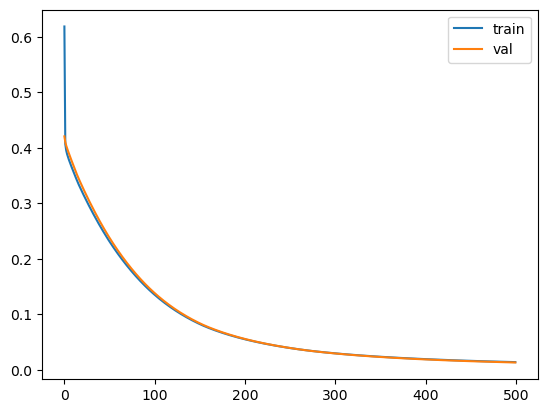

In [79]:
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")

plt.legend()
plt.show()

In [80]:
print(f"Average reconstruction error over the validation set : {val_loss[-1]}")

Average reconstruction error over the validation set : 0.01354710842851902


The loss is very low for both the validation and the training set, and it looks like it is still decreasing though it has slowed down quite a bit. I think the model is training well.